In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pylab as plt

In [3]:
test_y = np.load('./data/testall_y.npy')
bert_true_y = np.load('./data/true_y.npy')


In [4]:
with open('./data/prediction_cnnrl&cnn.npy', 'rb') as file:
    pred1 = np.load(file)
    pred2 = np.load(file)

pred_bert = np.load('./data/pred_y-2.npy')
pred_bert = pred_bert.reshape((62084, 53))

In [5]:
_temp_bert_y = np.zeros((len(bert_true_y), 53))
for i in range(len(bert_true_y)):
    _temp_bert_y[i, bert_true_y[i]] = 1
bert_true_y = _temp_bert_y

In [7]:
bert_ans = np.argmax(pred_bert.reshape((len(bert_true_y), 53)), axis=1)

In [8]:
np.argmax(pred_bert, axis=1).mean()

36.34717479543844

In [9]:
from scipy.special import softmax
soft_pred3 = softmax(pred_bert)
print(soft_pred3.shape)
print(pred_bert.shape)
soft_pred3_base = softmax(pred_bert+0.5*bert_true_y)
soft_pred3_rl = softmax(pred_bert+1.2*bert_true_y)


(62084, 53)
(62084, 53)


In [23]:
def filter_0(test_y, pred):
    filter_pred = []
    for i in range(len(pred)):
        if np.argmax(test_y[i])!=0:
            filter_pred.append(pred[i])
    return np.array(filter_pred)

In [24]:
filter_pred1 = filter_0(test_y, pred1)
filter_pred2 = filter_0(test_y, pred2)
filter_test_y = filter_0(test_y, test_y)

In [11]:
from sklearn.metrics import precision_recall_curve, roc_curve
prec4, recall4, _ = precision_recall_curve(bert_true_y.ravel(), soft_pred3_base.ravel())
prec3, recall3, _ = precision_recall_curve(bert_true_y.ravel(), soft_pred3_rl.ravel())

In [12]:

prec1, recall1, _ = precision_recall_curve(test_y[:, 1:].ravel(), pred1[:, 1:].ravel())
prec2, recall2, _ = precision_recall_curve(test_y[:, 1:].ravel(), pred2[:, 1:].ravel())


In [55]:
filter_prec1, filter_recall1, _ = precision_recall_curve(filter_test_y.ravel(), filter_pred1.ravel())
filter_prec2, filter_recall2, _ = precision_recall_curve(filter_test_y.ravel(), filter_pred2.ravel())

In [10]:
def converter(pred):
    pred = pred.reshape((62084, 53))
    temp = np.zeros(pred.shape)
    for i in range(len(pred)):
        temp[i, np.argmax(pred[i])]=1
    return temp
converter(soft_pred3_base)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
from sklearn.metrics import roc_auc_score, auc, f1_score, accuracy_score, balanced_accuracy_score, recall_score
def eval(true_y, pred, name):
    result = {}
    result['model'] = name
    result['F1 macro'] = f1_score(true_y, pred, average='macro')
    result['F1 micro'] = f1_score(true_y, pred, average='micro')
    result['ACC'] = accuracy_score(true_y, pred)
    result['Recall macro'] = recall_score(true_y, pred, average = 'macro')
    result['Recall micro'] = recall_score(true_y, pred, average = 'micro')
    return result

In [22]:
result1 = eval(converter(bert_true_y), converter(soft_pred3_base), 'BERT(base)')
result2 = eval(converter(bert_true_y), converter(soft_pred3_rl), 'BERT+RL')

In [23]:
def build_df(r1, r2):
    table_df = pd.DataFrame([r1, r2])
    print(table_df)

build_df(result1, result2)

model  F1 macro  F1 micro       ACC  Recall macro  Recall micro
0  BERT(base)  0.177507  0.479528  0.479528      0.158166      0.479528
1     BERT+RL  0.235491  0.561288  0.561288      0.219092      0.561288


## Precision Recall Curve

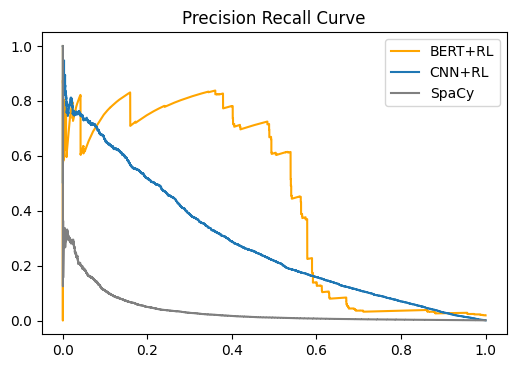

In [13]:
plt.figure(dpi=100)
plt.plot(recall3, prec3, label='BERT+RL', color='orange')
plt.plot(recall1, prec1, label='CNN+RL')
plt.plot(recall2, prec2, label='SpaCy', color='grey')

#plt.plot(recall4, prec4, label='BERT(base)')
plt.legend()
plt.title('Precision Recall Curve')
plt.savefig('./out/precision_recall.png')

Text(0.5, 1.0, 'Precision Recall Curve')

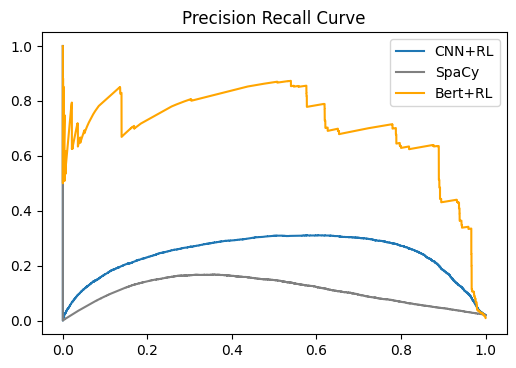

In [59]:
plt.figure(dpi=100)
plt.plot(filter_recall1, filter_prec1, label='CNN+RL')
plt.plot(filter_recall2, filter_prec2, label='SpaCy', color='grey')
plt.plot(recall3, prec3, label='Bert+RL', color='orange')
plt.legend()
plt.title('Precision Recall Curve')

### Plot by labels

In [32]:
def pr_curve_labels(pred_y, true_y):
    label_df = pd.read_csv('./origin_data/relation2id.txt', header=None, index_col=None, sep=' ')
    label_list = label_df.iloc[:, 0].to_list()
    precision = dict()
    recall = dict()
    curves = []
    avg_prec = []
    plt.figure(dpi=200)
    for i in range(len(test_y[0])):
        precision[i], recall[i], _ = precision_recall_curve(true_y[:, i],
                                                            pred_y[:, i])
        label_curve, = plt.plot(recall[i], precision[i], lw=2, label=label_list[i])
        avg_prec.append(precision[i].mean())
        curves.append(label_curve)
    sorted_curves = sorted(curves, key=lambda x:avg_prec[curves.index(x)], reverse=True)
    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(handles=sorted_curves[:10], loc=(1.04, 0))
    plt.title("Precision Recall Curve by Labels")
    return precision, recall

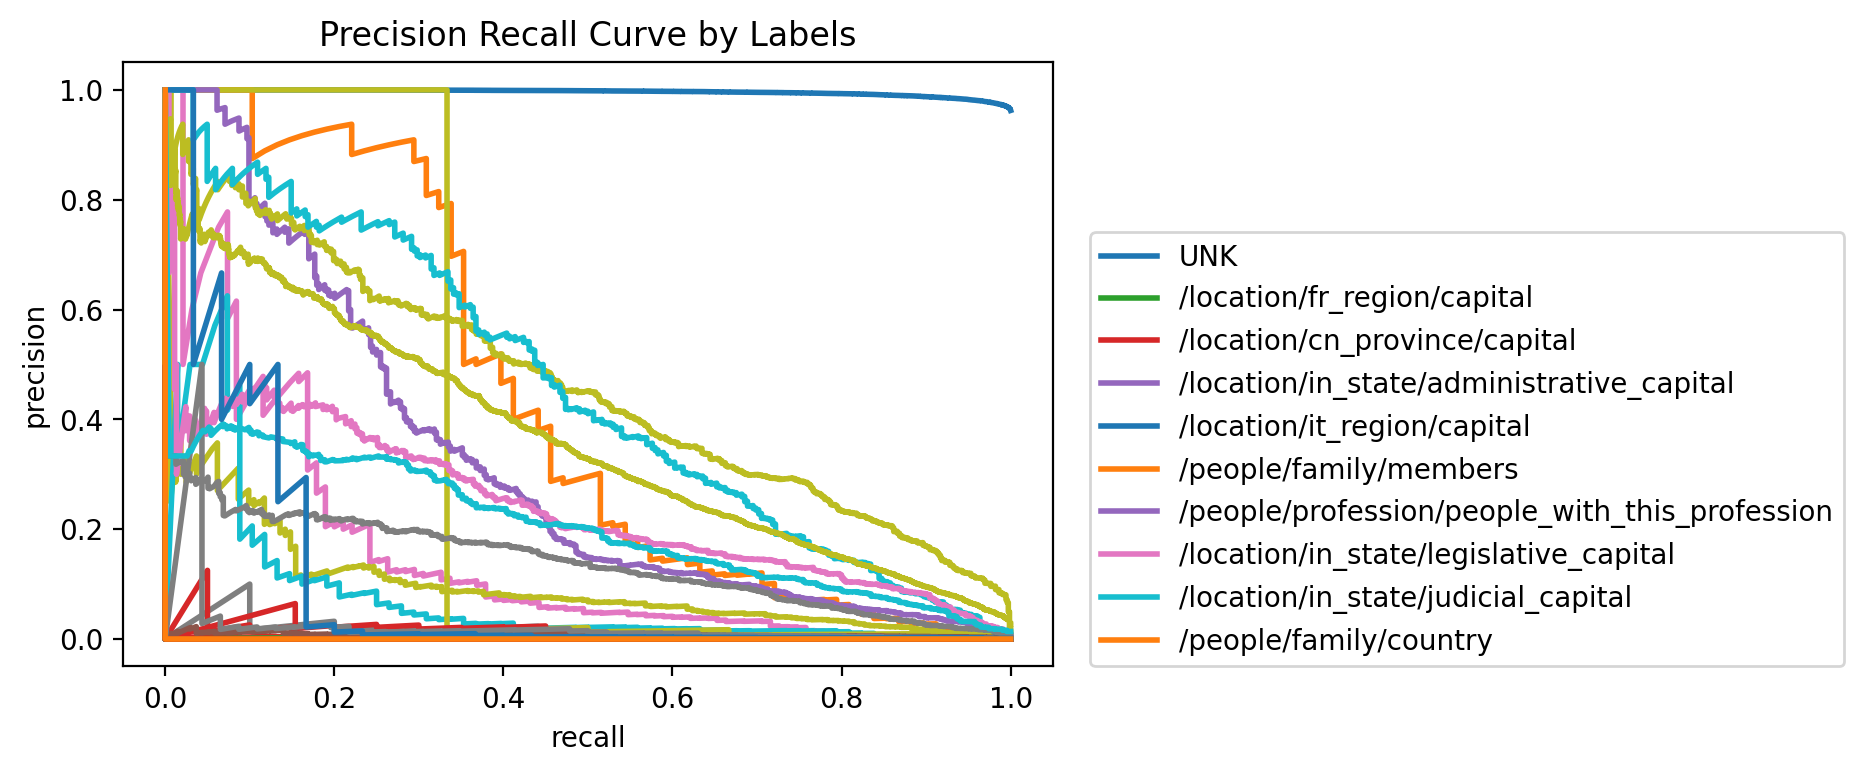

In [35]:
precision1, recall1 = pr_curve_labels(pred1, test_y)

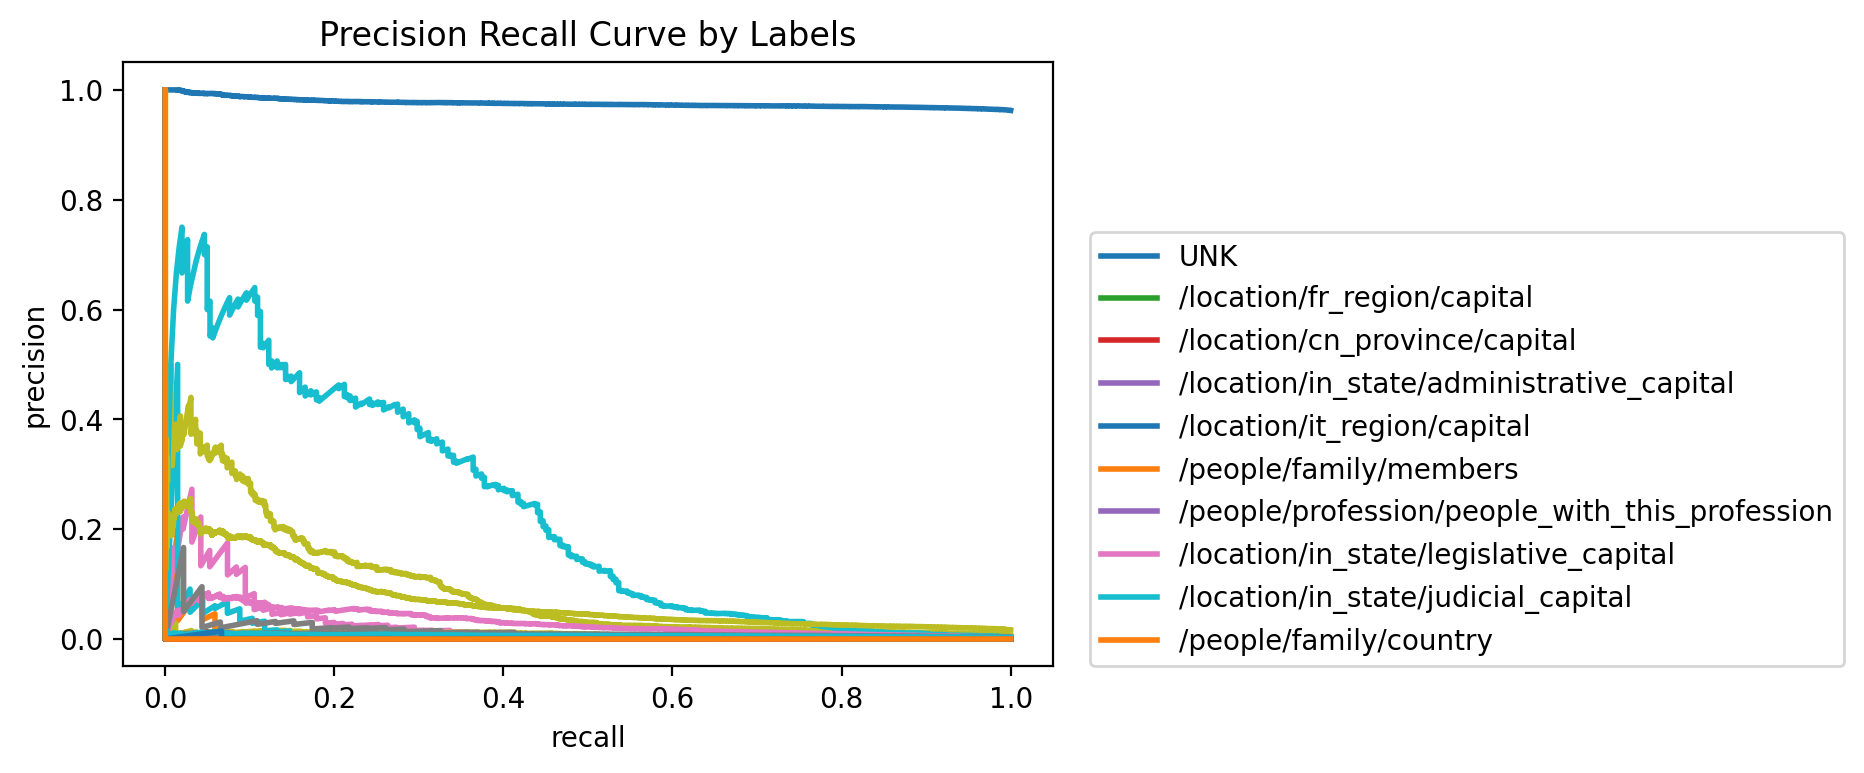

In [36]:
precision2, recall2 = pr_curve_labels(pred2, test_y)

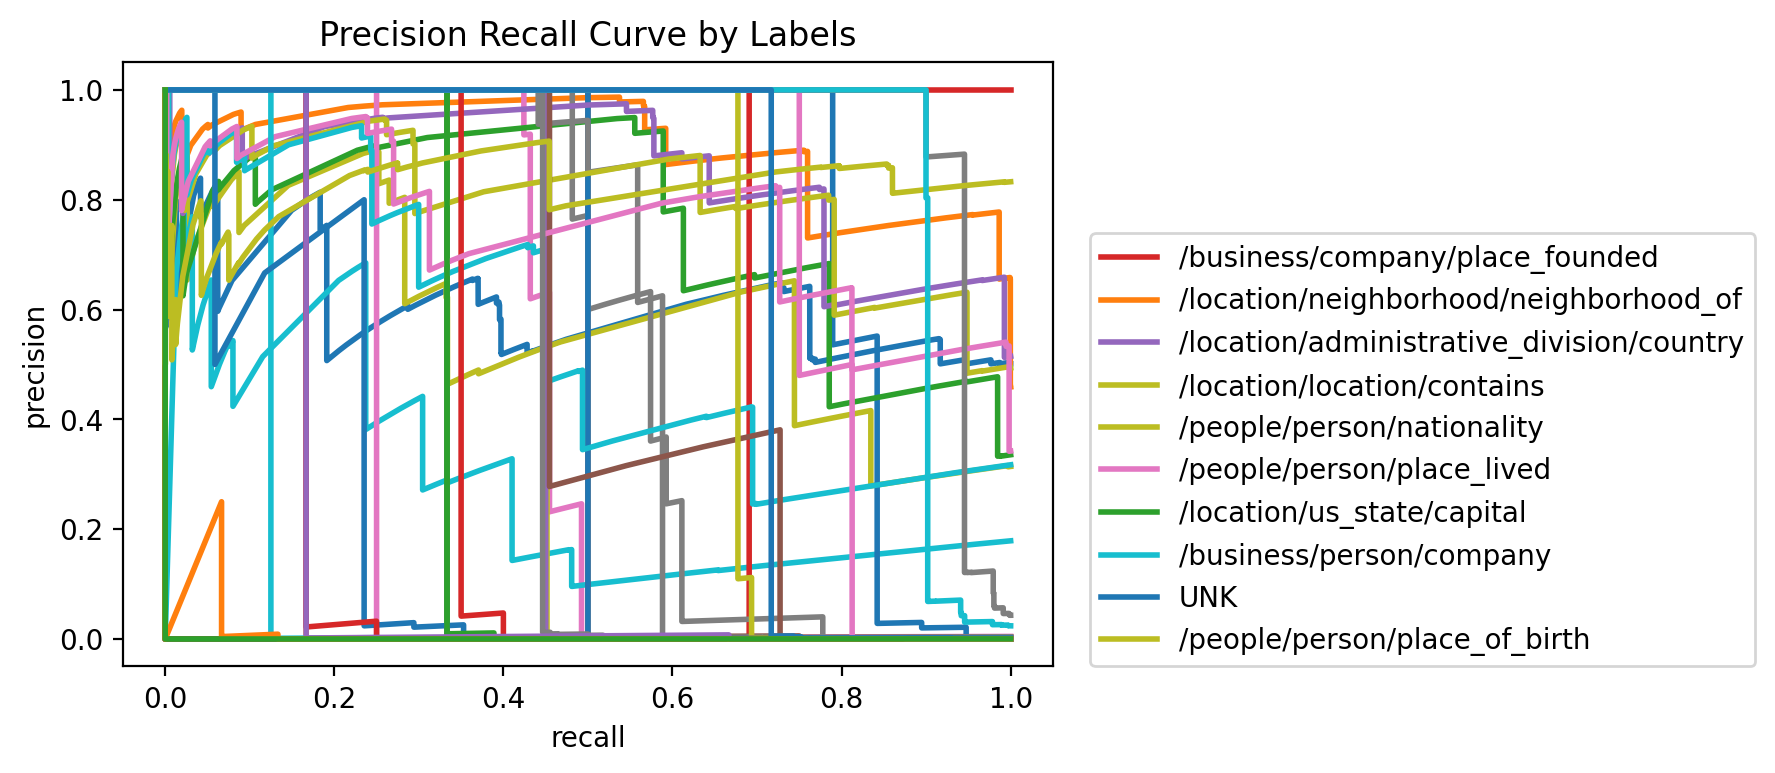

In [37]:
precision3, recall3 = pr_curve_labels(pred_bert.reshape((62084, 53)), test_y_bert)

In [50]:
def analysis

In [60]:
filter_test_y_1d = np.array([np.argmax(i) for i in filter_test_y])
filter_pred1_1d = np.array([np.argmax(i) for i in filter_pred1])
filter_pred2_1d = np.array([np.argmax(i) for i in filter_pred2])
pred3 = pred_bert.reshape((62084, 53))
pred3_1d = np.array([np.argmax(i) for i in pred3])

In [62]:
test_y_1d = np.array([np.argmax(i) for i in test_y])
pred1_1d = np.array([np.argmax(i) for i in pred1])
pred2_1d = np.array([np.argmax(i) for i in pred2])
pred3 = pred_bert.reshape((62084, 53))
pred3_1d = np.array([np.argmax(i) for i in pred3])

In [59]:
from sklearn.metrics import roc_auc_score, auc, f1_score, accuracy_score, balanced_accuracy_score
def analysis(true_y, predict):
    f1_macro = f1_score(true_y, predict, average='macro')
    f1_micro = f1_score(true_y, predict, average='micro')
    f1_weighted = f1_score(true_y, predict, average='weighted')
    
    acc = accuracy_score(true_y, predict)
    balanced_acc = balanced_accuracy_score(true_y, predict)
    
    result = {}
    result['f1_macro'] = f1_macro
    result['f1_micro'] = f1_micro
    result['f1_weighted'] = f1_weighted
    result['acc'] = acc
    result['balanced_acc'] = balanced_acc
    print(result)

In [64]:
analysis(true_y, pred3_1d)

{'f1_macro': 0.014673706137058993, 'f1_micro': 0.274563494620192, 'f1_weighted': 0.23079579987209226, 'acc': 0.274563494620192, 'balanced_acc': 0.019893507779738334}


In [42]:
f1_score(true_y, pred3_1d, average='micro')

0.6232845821789833

In [75]:
from sklearn.metrics import roc_auc_score, auc, f1_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score
'''
The result contains 0.
'''
def compare_f1(t_y, predict_1, predict_2):
    f1 = []
    f1.append(f1_score(t_y, predict_1, average='micro'))
    f1.append(f1_score(t_y, predict_2, average='micro'))
    f1.append(f1_score(true_y, pred3_1d, average='micro'))
    f1.append(f1_score(t_y, predict_1, average='macro'))
    f1.append(f1_score(t_y, predict_2, average='macro'))
    f1.append(f1_score(true_y, pred3_1d, average='macro'))
    acc = []
    acc.append(accuracy_score(t_y, predict_1))
    acc.append(accuracy_score(t_y, predict_2))
    acc.append(accuracy_score(true_y, pred3_1d))
    [acc.append(0) for i in range(3)]

    prec = []
    prec.append(precision_score(t_y, predict_1, average='micro'))
    prec.append(precision_score(t_y, predict_2, average='micro'))
    prec.append(precision_score(true_y, pred3_1d, average='micro'))
    prec.append(precision_score(t_y, predict_1, average='macro'))
    prec.append(precision_score(t_y, predict_2, average='macro'))
    prec.append(precision_score(true_y, pred3_1d, average='macro'))
    stat = pd.DataFrame({'F1':f1, 'ACC':acc, 'Pre': prec}, index=None)
    print(stat)

In [76]:
compare_f1(filter_test_y_1d, filter_pred1_1d, filter_pred2_1d)

F1       ACC       Pre
0  0.250000  0.250000  0.250000
1  0.025916  0.025916  0.025916
2  0.623285  0.623285  0.623285
3  0.091038  0.000000  0.260696
4  0.017207  0.000000  0.090074
5  0.267311  0.000000  0.372569


In [10]:
mask = []
for i in pred1_1d:
    if i==0:        
        mask.append(False)
    else:
        mask.append(True)
noz_test1_y = test_y_1d[mask]
noz_pred1 = pred1_1d[mask]
analysis(noz_test1_y, noz_pred1)

mask = []
for i in pred2_1d:
    if i==0:        
        mask.append(False)
    else:
        mask.append(True)
noz_test2_y = test_y_1d[mask]
noz_pred2 = pred2_1d[mask]
analysis(noz_test2_y, noz_pred2)

{'f1_macro': 0.2575307451967701, 'f1_micro': 0.4453967376278684, 'f1_weighted': 0.2875322012983325, 'acc': 0.4453967376278684, 'balanced_acc': 0.33466256909481323}
{'f1_macro': 0.097077702062243, 'f1_micro': 0.2372159090909091, 'f1_weighted': 0.10184308091200817, 'acc': 0.2372159090909091, 'balanced_acc': 0.375}


## ROC

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
def draw_roc(true_y, predict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    fpr['macro'], tpr['macro'], _=roc_curve(true_y.ravel(), predict.ravel())
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    
    plt.figure()
    plt.plot(fpr['macro'], tpr['macro'], color='orange')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [21]:
draw_roc(test_y_1d, pred1_1d)

ValueError: multiclass format is not supported

In [22]:
from sklearn.metrics import confusion_matrix
def cal_confusion_matrix(true_y, predict):
    label_df = pd.read_csv('./origin_data/relation2id.txt', header=None, index_col=None, sep=' ')
    label_list = label_df.iloc[:, 0].to_list()
    cm = confusion_matrix(true_y, predict)
    return cm

In [29]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    label_df = pd.read_csv('./origin_data/relation2id.txt', header=None, index_col=None, sep=' ')
    label_list = label_df.iloc[:, 0].to_list()
    classes = [i for i in range(len(label_list))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig1 = plt.figure(figsize=(10, 10), dpi=500)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [35]:
import seaborn as sns

cm = cal_confusion_matrix(test_y_1d, pred1_1d)
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
label_df = pd.read_csv('./origin_data/relation2id.txt', header=None, index_col=None, sep=' ')
label_list = label_df.iloc[:, 0].to_list()
target_names = [i for i in range(len(label_list))]


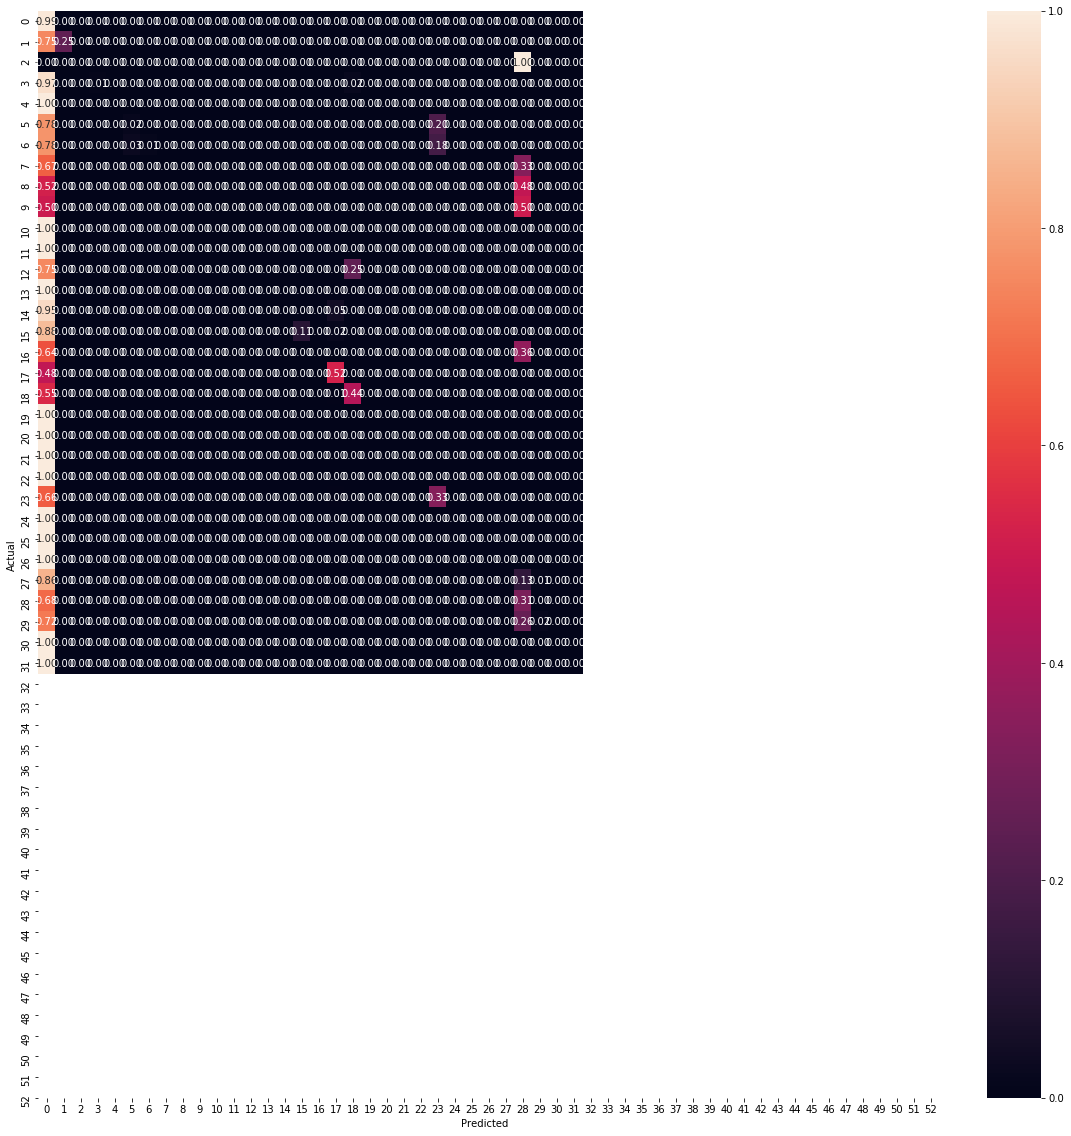

In [39]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=True)

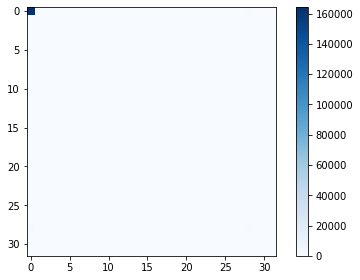

In [41]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()